In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import matplotlib.pyplot as plt

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-10-29 11:59:14.391 | INFO     | celeri.celeri:get_logger:7584 - Read: ../data/command/japan_command_cmi.json
2024-10-29 11:59:14.392 | INFO     | celeri.celeri:get_logger:7585 - RUN_NAME: 0000000413
2024-10-29 11:59:14.392 | INFO     | celeri.celeri:get_logger:7586 - Write log file: ../runs/0000000413/0000000413.log
2024-10-29 11:59:14.392 | INFO     | celeri.celeri:read_data:451 - Reading data files
2024-10-29 11:59:14.424 | SUCCESS  | celeri.celeri:read_data:455 - Read: ../data/segment/qp_japan_segment.csv
2024-10-29 11:59:14.426 | SUCCESS  | celeri.celeri:read_data:460 - Read: ../data/block/japan_block.csv
2024-10-29 11:59:14.426 | SUCCESS  | celeri.celeri:read_data:467 - Read: ../data/mesh/japan_mesh_parameters_cmi.json

2024-10-29 11:59:14.480 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/nankai.msh

2024-10-29 11:59:14.486 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/japan.msh

2024-10-29 11:59:14.497 | SUCCESS  | celeri.celeri:read_mesh:446 

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

2024-10-29 11:59:14.848 | INFO     | celeri.celeri:get_elastic_operators:2053 - Computing elastic operators


Calculating Okada partials for segments: 100%|██████████| 481/481 [00:04<00:00, 118.45it/s]

2024-10-29 11:59:18.924 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh



Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:05<00:00, 351.22it/s]

2024-10-29 11:59:24.341 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
2024-10-29 11:59:24.342 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh



Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:07<00:00, 356.84it/s]

2024-10-29 11:59:31.688 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh


2024-10-29 11:59:31.689 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh


Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:00<00:00, 334.98it/s]

2024-10-29 11:59:32.380 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh
2024-10-29 11:59:32.380 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh



Calculating cutde partials for triangles: 100%|██████████| 76/76 [00:00<00:00, 361.62it/s]

2024-10-29 11:59:32.593 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan_mock_cmi.msh


2024-10-29 11:59:33.010 | INFO     | celeri.celeri:get_slip_rate_constraints:3302 - No slip rate constraints
2024-10-29 11:59:33.189 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4493 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-10-29 11:59:34.009 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4522 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-10-29 11:59:34.009 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4493 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-10-29 11:59:36.381 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4522 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-10-29 11:59:36.382 | INFO     | celeri.celeri:get_eigenvectors_to_tde_slip:4493 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh
2024-10-29 11:59:36.385 | SUCCESS  | celeri.celeri:get_eigenvectors_to_tde_slip:4522 - Finish: Eigenvectors to TDE slip for me

In [5]:
for mesh_idx in range(3):
    operators.rotation_to_tri_slip_rate[mesh_idx] = (
        celeri.get_rotation_to_tri_slip_rate_partials(
            meshes[mesh_idx], mesh_idx, segment, block
        )
    )
    # Trim tensile rows
    tri_keep_rows = celeri.get_keep_index_12(
        np.shape(operators.rotation_to_tri_slip_rate[mesh_idx])[0]
    )
    operators.rotation_to_tri_slip_rate[mesh_idx] = operators.rotation_to_tri_slip_rate[
        mesh_idx
    ][tri_keep_rows, :]

# Solve bounded KL+QP problem

2024-10-29 11:59:36.774 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4192 - USING TDE COUPLING BOUNDS FOR MESH 0
operators.eigenvectors_to_tde_slip[i].shape=(3804, 200)
operators.rotation_to_tri_slip_rate[i].shape=(3804, 63)


/Users/meade/Desktop/celeri/celeri/celeri.py:4263: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(to_plot)), aspect="auto")


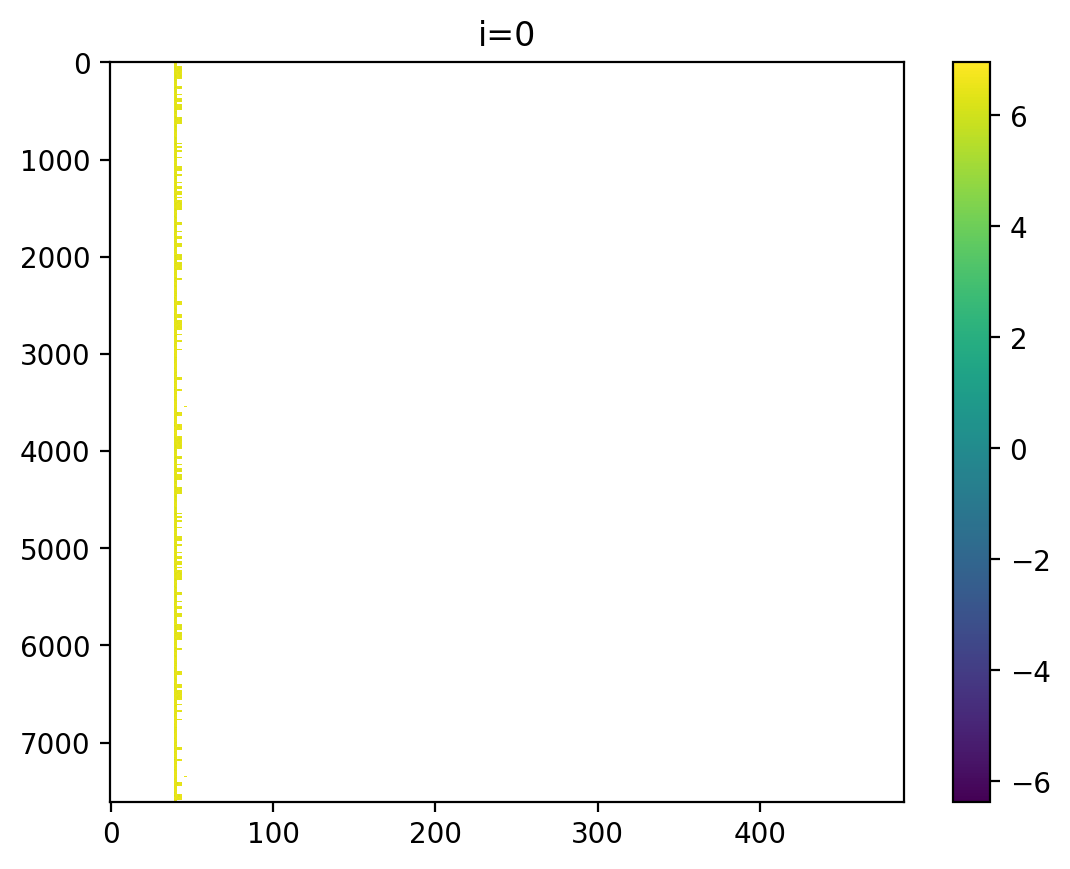

2024-10-29 11:59:37.072 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 1


/Users/meade/Desktop/celeri/celeri/celeri.py:4185: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(to_plot)), aspect="auto")


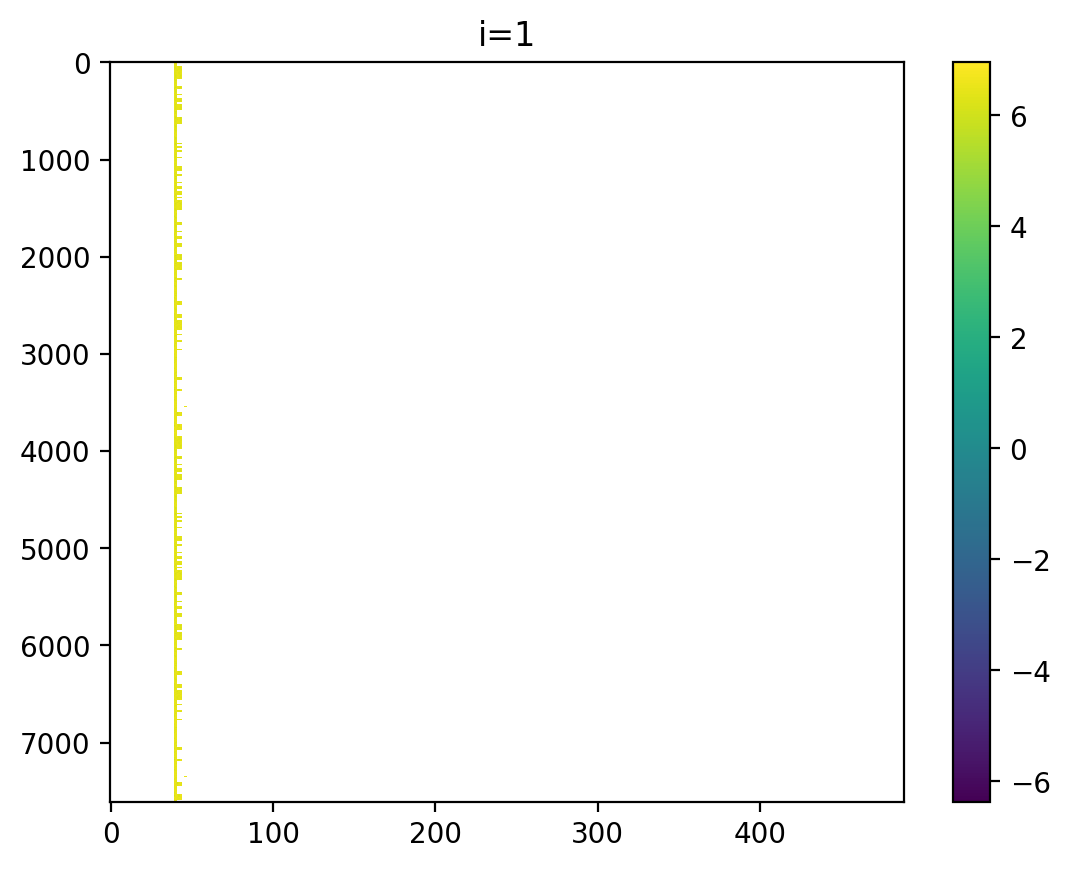

2024-10-29 11:59:37.356 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 2


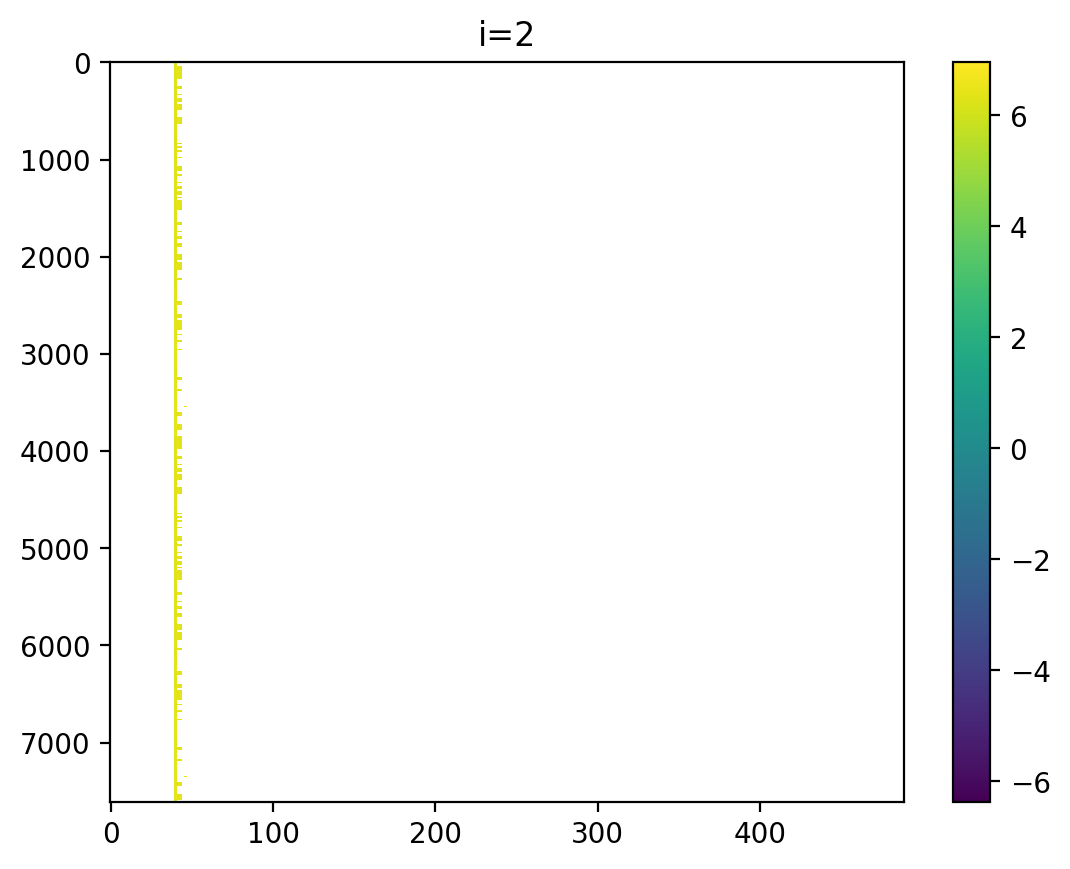

2024-10-29 11:59:37.636 | INFO     | celeri.celeri:get_qp_tde_inequality_operator_and_data_vector:4136 - USING TDE SLIP RATE BOUNDS FOR MESH 3


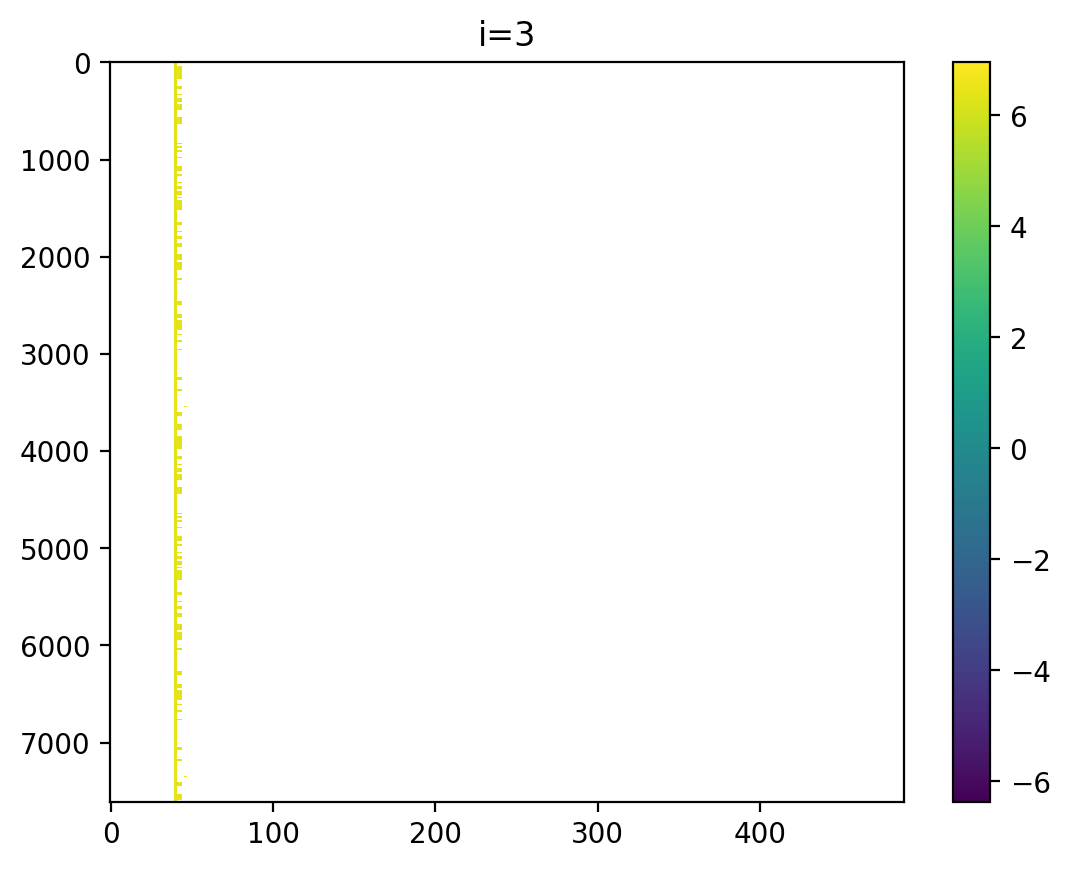

2024-10-29 11:59:37.916 | INFO     | celeri.celeri:get_slip_rate_bounds:4099 - No hard slip rate bounds
     pcost       dcost       gap    pres   dres
 0: -2.8532e+04 -2.1480e+07  2e+07  3e-17  6e-13
 1: -4.2923e+04 -5.1194e+06  5e+06  1e-15  1e-13
 2: -4.2706e+04 -4.6065e+06  5e+06  1e-15  1e-13
 3: -4.4427e+04 -7.0270e+05  7e+05  1e-15  8e-14
 4: -4.5809e+04 -3.4014e+05  3e+05  1e-15  2e-14
 5: -4.6859e+04 -8.2715e+04  4e+04  1e-15  2e-14
 6: -4.7522e+04 -5.3408e+04  6e+03  1e-15  5e-15
 7: -4.7750e+04 -5.0386e+04  3e+03  1e-15  3e-15
 8: -4.7761e+04 -5.0348e+04  3e+03  1e-15  3e-15
 9: -4.7853e+04 -4.9413e+04  2e+03  1e-15  2e-15
10: -4.7925e+04 -4.8645e+04  7e+02  1e-15  1e-14
11: -4.7956e+04 -4.8326e+04  4e+02  1e-15  4e-15
12: -4.7971e+04 -4.8163e+04  2e+02  1e-15  2e-15
13: -4.7975e+04 -4.8115e+04  1e+02  1e-15  3e-15
14: -4.7980e+04 -4.8055e+04  8e+01  1e-15  2e-15
15: -4.7980e+04 -4.8046e+04  7e+01  1e-15  1e-15
16: -4.7982e+04 -4.8012e+04  3e+01  1e-15  4e-15
17: -4.7983e+04

In [6]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

# Plot KL+QP estimation

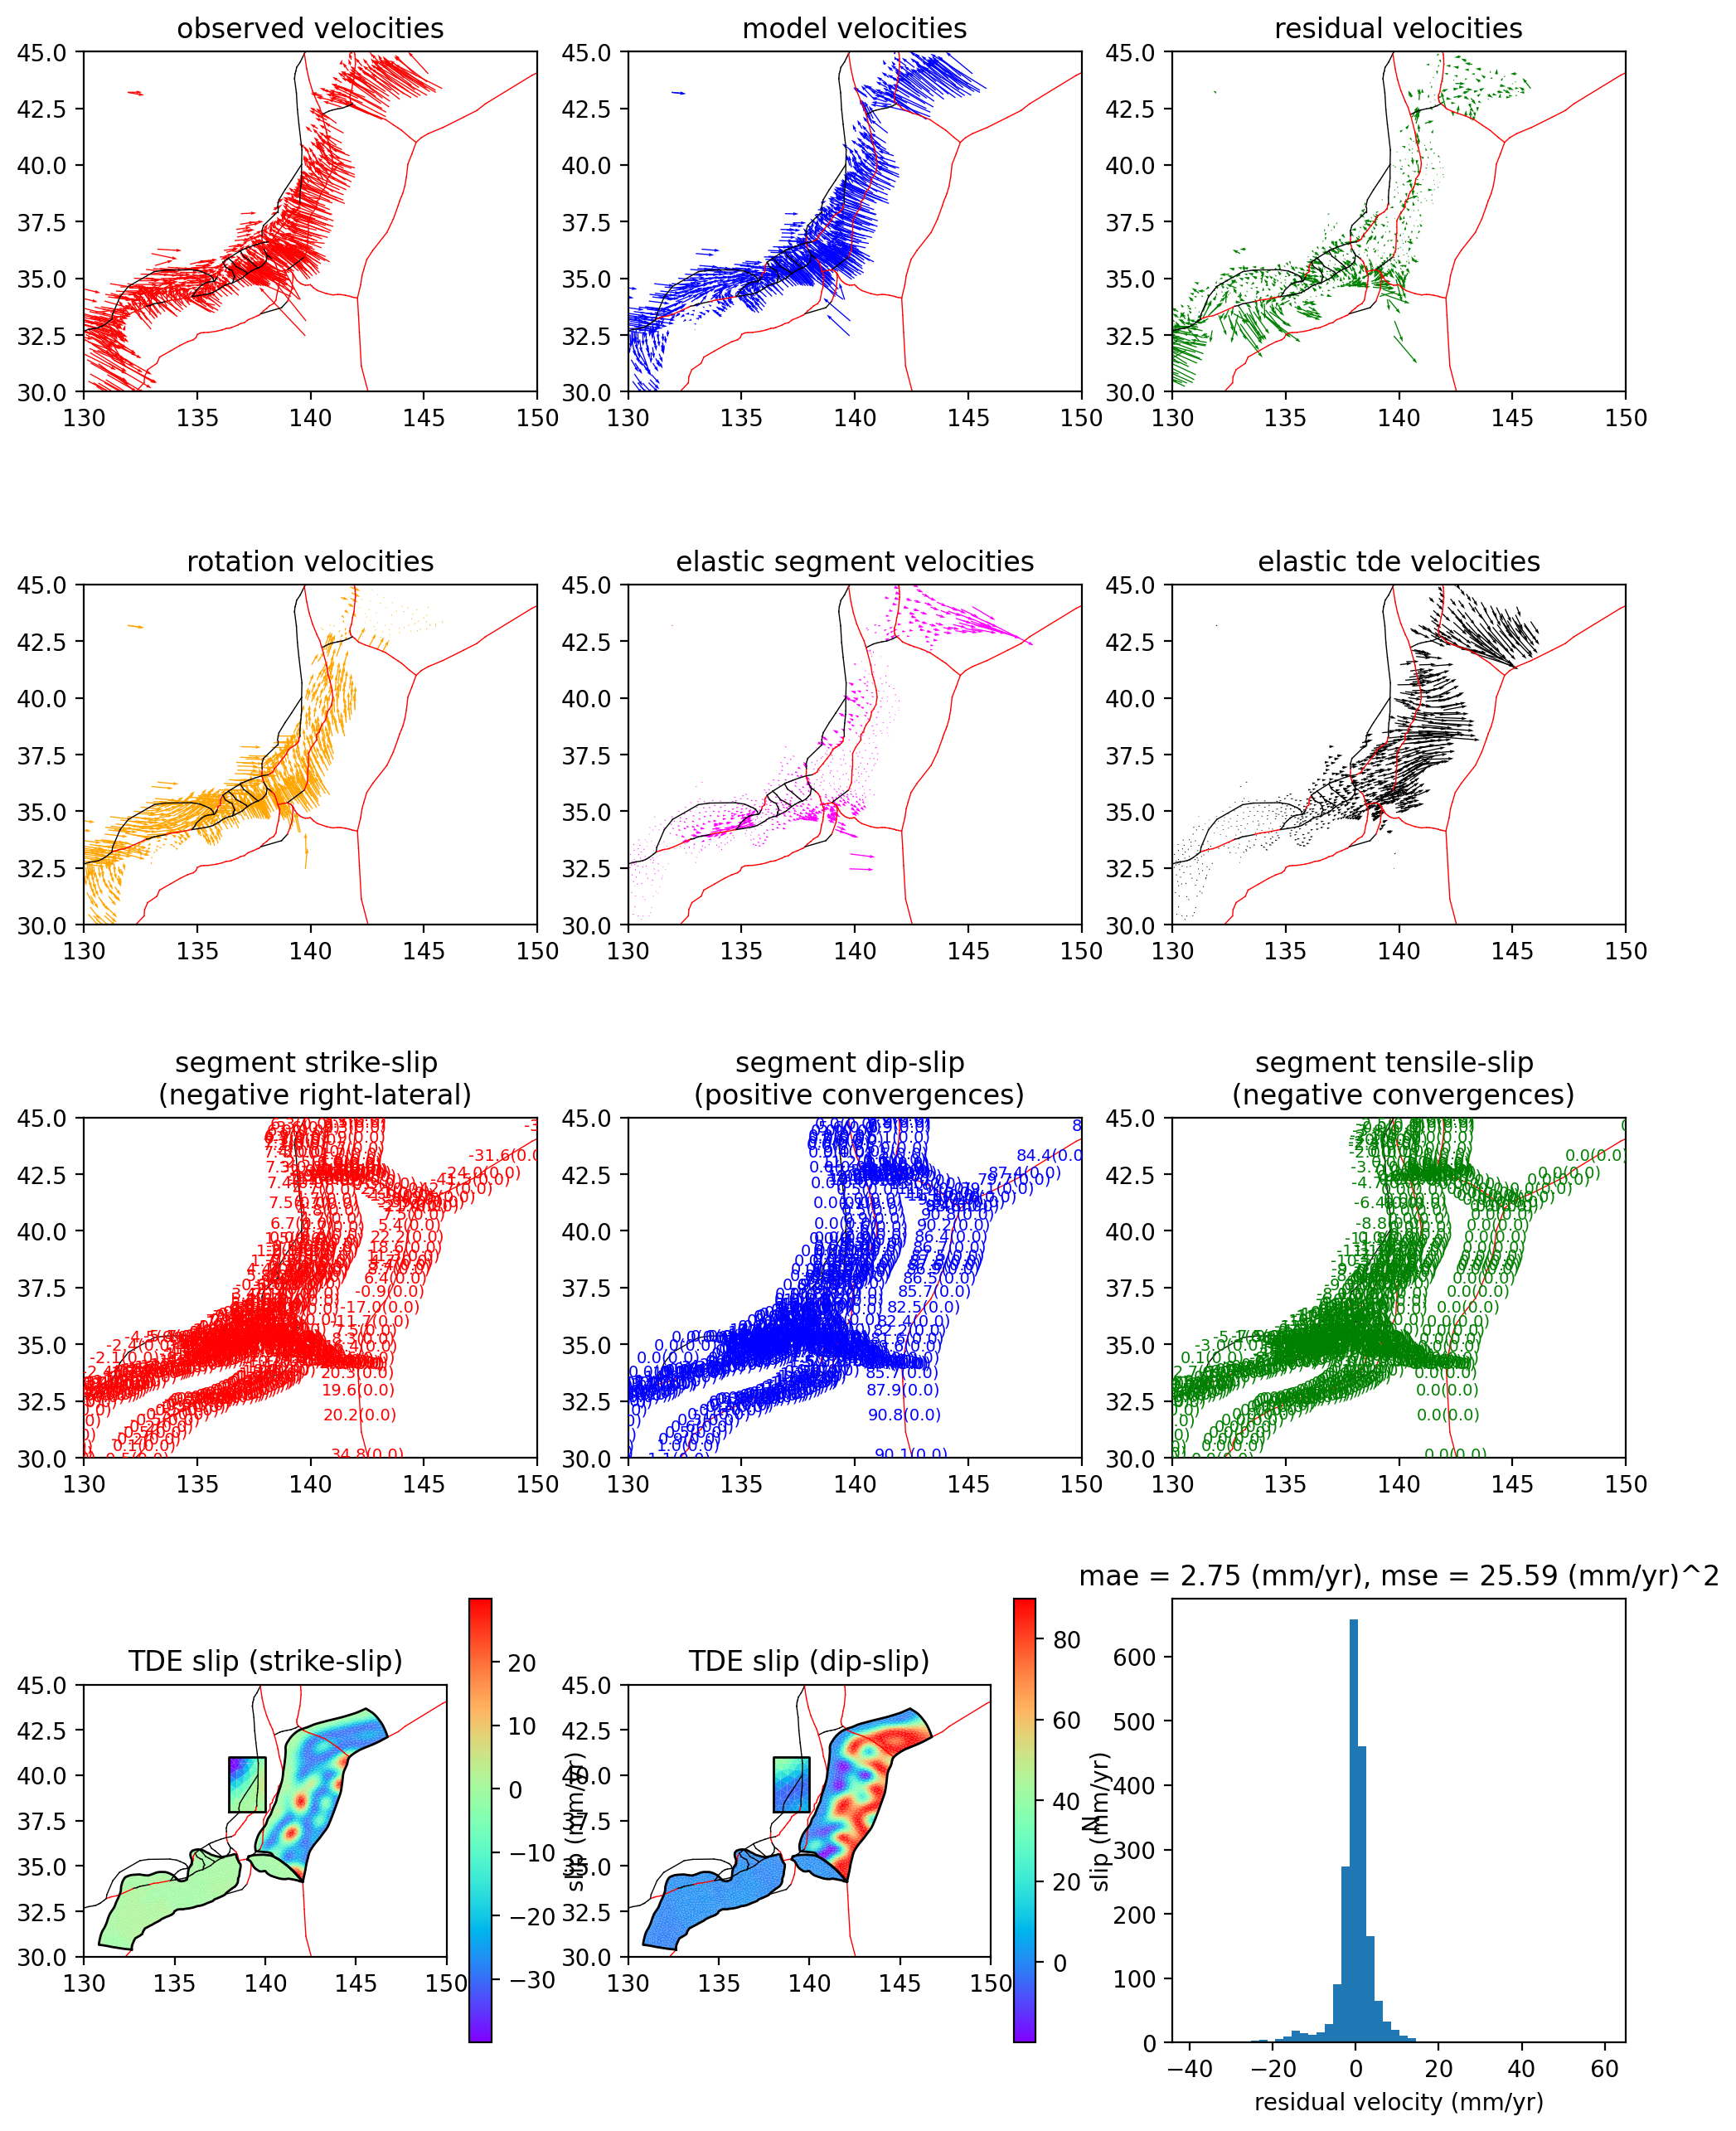

2024-10-29 11:59:43.136 | SUCCESS  | celeri.celeri:plot_estimation_summary:6638 - Wrote figures../runs/0000000413/plot_estimation_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [7]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

i=0
operators.rotation_to_tri_slip_rate[i].shape=(3804, 63)
2 * meshes[i].n_tde=3804
i=1
operators.rotation_to_tri_slip_rate[i].shape=(5242, 63)
2 * meshes[i].n_tde=5242
i=2
operators.rotation_to_tri_slip_rate[i].shape=(462, 63)
2 * meshes[i].n_tde=462


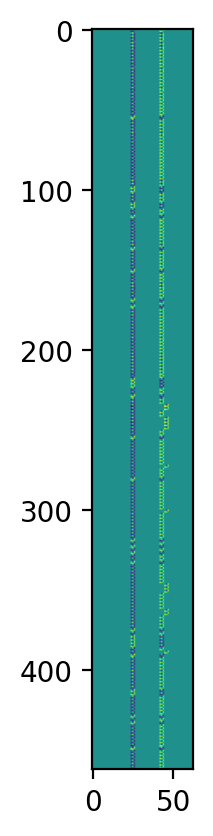

In [8]:
for i in range(0, 3):
    print(f"{i=}")
    print(f"{operators.rotation_to_tri_slip_rate[i].shape=}")
    print(f"{2 * meshes[i].n_tde=}")


plt.imshow(operators.rotation_to_tri_slip_rate[2])
plt.show()